# Analysis: Geant4 simulation of Ni-Cf source
The simulation launches $^{252}$Cf decays from the center of a spherical volume composed of a mixture of NiO and polyethylene. The true Monte Carlo information, including the particles produced in each event and relevant kinematic information, is stored in an HDF5 ntuple which can be read and processed in this notebook.

In [1]:
import h5py
import tables as tb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def read_hdf5_to_df(fname):
    """
    Reads an output HDF5 file from the nisource Geant4 simulation into a Pandas DataFrame.
    """
    
    # Open the file and get the ntuple.
    fn = h5py.File(fname,'r')
    ntuple = fn['default_ntuples']['nisource']
    
    # Fill a dictionary with the ntuple column values.
    df_values = {}
    for col in list(ntuple):

        # Only process H5 groups with actual data.
        if(isinstance(ntuple[col],h5py._hl.group.Group)):
            #print("Adding column",col,"...")
            if(ntuple[col]['pages'].dtype == object):
                df_values[col] = [x.decode('utf-8') for x in ntuple[col]['pages'][:]]
            else:
                df_values[col] = ntuple[col]['pages'][:]
             
    # Create the dataframe.
    df = pd.DataFrame.from_dict(df_values)
    
    # Add composite columns.
    ri = (df.xi**2 + df.yi**2 + df.zi**2)**0.5
    rf = (df.xf**2 + df.yf**2 + df.zf**2)**0.5
    Ki = (df.pxi**2 + df.pyi**2 + df.pzi**2)**0.5
    Kf = (df.pxf**2 + df.pyf**2 + df.pzf**2)**0.5
    
    df['ri'] = ri  # initial radius
    df['rf'] = rf  # final radius
    df['Ki'] = Ki  # initial kinetic energy
    df['Kf'] = Kf  # final kinetic energy
    
    return df

### Read in the ntuple

In [3]:
!wget https://www.dropbox.com/s/aig7xqq1ffluig6/nicf_source_ntuple.hdf5

--2021-04-16 20:10:09--  https://www.dropbox.com/s/aig7xqq1ffluig6/nicf_source_ntuple.hdf5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:6024:18::a27d:4412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/aig7xqq1ffluig6/nicf_source_ntuple.hdf5 [following]
--2021-04-16 20:10:10--  https://www.dropbox.com/s/raw/aig7xqq1ffluig6/nicf_source_ntuple.hdf5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7895369adb0c2ea04e1eaa6aa8.dl.dropboxusercontent.com/cd/0/inline/BMsOHrjHnVZumeLTyUwVtmQwJ74nLFK23v9HyfcP0QajRQFlebqaXsxJ7G-DjCMInfmcwHJ4aHws_bPitfnm_DS840_3VWGB2Nd-RGHeRBpLDlbGl9cngrGPH3Waj_Wp9vnY8cZiH-GVREMFRUCJFcg0/file# [following]
--2021-04-16 20:10:10--  https://uc7895369adb0c2ea04e1eaa6aa8.dl.dropboxusercontent.com/cd/0/inline/BMsOHrjHnVZumeLTyUwVtmQwJ74nLFK23v9HyfcP0QajRQFlebqaXs

In [4]:
df = read_hdf5_to_df('nicf_source_ntuple.hdf5')
df.head()

,event,mass,parentID,particleName,pxf,pxi,pyf,pyi,pzf,pzi,...,xf,xi,yf,yi,zf,zi,ri,rf,Ki,Kf
0,0,234763.351319,0,Cf252,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
1,0,3727.379000,1,alpha,0.00000,132.848650,-0.000000,-162.682253,34.828944,34.828944,...,9.324779e-03,0.000000e+00,-1.141883e-02,0.000000e+00,2.444678e-03,0.000000e+00,0.0,1.494382e-02,212.902172,34.828944
2,0,231029.751654,1,Cm248[43.400],-132.84865,-132.848650,162.682253,162.682253,-34.828944,-34.828944,...,-9.952832e-309,0.000000e+00,1.218792e-308,0.000000e+00,-2.609335e-309,0.000000e+00,0.0,0.000000e+00,212.902172,212.902172
3,0,0.510999,2,e-,0.00000,0.151762,-0.000000,-0.092054,-0.089882,-0.089882,...,1.679738e-03,-9.952832e-309,-1.018874e-03,1.218792e-308,-9.948400e-04,-2.609335e-309,0.0,2.202120e-03,0.198958,0.089882
4,0,0.510999,2,e-,0.00000,0.000233,-0.000000,-0.013831,0.004203,0.004203,...,1.314623e-08,-9.952832e-309,-7.794640e-07,1.218792e-308,2.368486e-07,-2.609335e-309,0.0,8.147602e-07,0.014457,0.004203


### Analysis: gamma energies

In [5]:
# Select gamma events that made it out of the source.
df_gammas_world = df[(df.particleName == 'gamma') & (df.volFinal == 'World')]

Text(0, 0.5, 'Counts/bin')

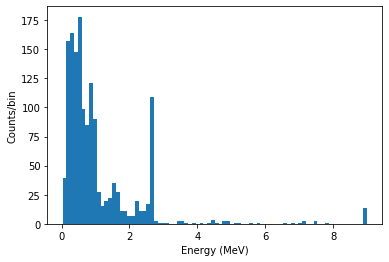

In [6]:
plt.hist(df_gammas_world.Kf,bins=80)
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts/bin')

### Misc.

(array([1.21439e+05, 1.40600e+03, 1.55200e+03, 1.40900e+03, 1.02900e+03,
        1.23500e+03, 1.20600e+03, 1.22500e+03, 9.36000e+02, 1.10600e+03,
        1.06500e+03, 1.04600e+03, 9.92000e+02, 1.01100e+03, 1.04100e+03,
        1.14800e+03, 1.05800e+03, 1.12200e+03, 1.06500e+03, 9.49000e+02,
        9.52000e+02, 9.54000e+02, 8.29000e+02, 8.05000e+02, 8.49000e+02,
        8.61000e+02, 7.96000e+02, 8.70000e+02, 6.86000e+02, 6.48000e+02,
        5.52000e+02, 4.98000e+02, 4.52000e+02, 3.88000e+02, 3.65000e+02,
        0.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 6.89800e+03]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  7

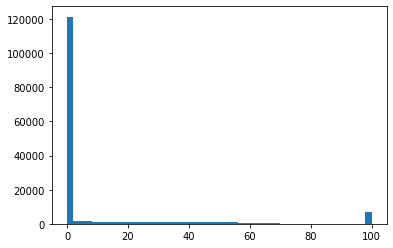

In [7]:
# Distribution of final radial values for all particles.
plt.hist(df.rf,bins=50)

In [8]:
# Select events containing Ni-59.
evts = df[df.particleName == 'Ni59'].event.values
evts

array([ 43,  43,  88,  88, 123, 127, 127, 127, 153, 166, 166, 208, 317,
       339, 411, 411, 563, 563, 567, 567, 578, 628, 640, 711, 711, 761,
       762, 846, 856, 856, 856, 897, 943, 949, 961, 986], dtype=int32)

In [9]:
# Print the energies of all gammas in one of these events.
df_gammas = df[(df.event == evts[0]) & (df.particleName == 'gamma')]
print(df_gammas.Kf.values)

[2.28378534 0.4250406  0.4060755  0.80384006 0.00478142 0.09569516
 0.0040158  0.30819517 0.59121829 1.72152924 0.57550483 1.12688085
 0.02467705]


In [10]:
# Create a list of all unique particles.
np.unique(df.particleName.values)

array(['Ac228', 'Ac228[20.190]', 'Ac228[33.070]', 'Ac228[6.280]',
       'Ac228[6.670]', 'Bi212', 'Bi212[115.183]', 'Bi212[238.632]',
       'Bi212[415.272]', 'C12', 'C13', 'Cf252', 'Cm248', 'Cm248[143.800]',
       'Cm248[43.400]', 'Co59', 'Cu63', 'Ni58', 'Ni59', 'Ni60', 'Ni61',
       'Ni63', 'Np240', 'Np240[0.000X]', 'Np240[110.700]',
       'Np240[111.600]', 'Np240[189.700]', 'Np240[280.000]',
       'Np240[44.170X]', 'Np240[44.170]', 'Np240[61.400X]', 'O16',
       'Pb208', 'Pb208[2614.522]', 'Pb208[3197.711]', 'Pb208[3475.078]',
       'Pb208[3708.451]', 'Pb208[3919.966]', 'Pb208[3961.162]',
       'Pb208[4125.347]', 'Pb212', 'Po212', 'Po212[1512.700]',
       'Po212[1620.738]', 'Po212[1679.450]', 'Po212[1805.960]',
       'Po212[727.330]', 'Po216', 'Po216[549.760]', 'Pu240',
       'Pu240[1001.940]', 'Pu240[1030.550]', 'Pu240[1037.550]',
       'Pu240[1076.220]', 'Pu240[1115.530]', 'Pu240[1130.950]',
       'Pu240[1161.530]', 'Pu240[1177.630]', 'Pu240[1308.740]',
       'Pu240[1